In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,ConcatDataset
import os
import re
import wfdb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.signal import spectrogram
import librosa
import librosa.display
from sklearn.metrics import roc_auc_score

In [2]:
diagnostics={"NORM":['NORM','CSD'],
             "STTC":['NDT', 'NST_', 'DIG', 'LNGQT', 'ISC_', 'ISCAL', 'ISCIN', 'ISCIL', 'ISCAS', 'ISCLA', 'ANEUR', 'EL', 'ISCAN' ],
             "MI":['IMI', 'ASMI', 'ILMI', 'AMI', 'ALMI', 'INJAS', 'LMI', 'INJAL', 'IPLMI', 'IPMI', 'INJIN', 'INJLA', 'PMI', 'INJIL'],
             "HYP":['LVH', 'LAO/LAE', 'RVH', 'RAO/RAE', 'SEHYP'],
             "CD":['LAFB', 'IRBBB', '1AVB', 'IVCD', 'CRBBB', 'CLBBB', 'LPFB', 'WPW', 'ILBBB', '3AVB', '2AVB'],
             "OTHER":['AFLT', 'AFIB', 'PSVT', 'STACH', 'PVC', 'PACE', 'PAC']
            }

In [3]:
diagnostics['MI']

['IMI',
 'ASMI',
 'ILMI',
 'AMI',
 'ALMI',
 'INJAS',
 'LMI',
 'INJAL',
 'IPLMI',
 'IPMI',
 'INJIN',
 'INJLA',
 'PMI',
 'INJIL']

In [4]:
ecg_data=pd.read_csv('/home/ines/code/ptb-xl/ptbxl_database.csv')
ecg_data.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [5]:
ecg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21799 entries, 0 to 21798
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ecg_id                        21799 non-null  int64  
 1   patient_id                    21799 non-null  float64
 2   age                           21799 non-null  float64
 3   sex                           21799 non-null  int64  
 4   height                        6974 non-null   float64
 5   weight                        9421 non-null   float64
 6   nurse                         20326 non-null  float64
 7   site                          21782 non-null  float64
 8   device                        21799 non-null  object 
 9   recording_date                21799 non-null  object 
 10  report                        21799 non-null  object 
 11  scp_codes                     21799 non-null  object 
 12  heart_axis                    13331 non-null  object 
 13  i

In [6]:
#Merging the diagnosis into a superclass:
labels=[]
discard=[]
for index in range(ecg_data.shape[0]):
    counter=0
    temp_diag=ecg_data['scp_codes'][index]
    temp_diag=re.sub('{',"",str(temp_diag))
    temp_diag=re.sub('}',"",temp_diag)
    temp_diag=temp_diag.split(',')                 
    len_diag=len(temp_diag)
    for idx in range(len_diag):
        temp_d=temp_diag[idx]
        temp_d=temp_d.split(':')[0]
        temp_d=re.sub(r'[^\w\s]',"",temp_d)
        if temp_d in diagnostics['NORM']:
            label=0
            counter=1
        elif temp_d in diagnostics['STTC']:
            label=1
            counter=1
        elif temp_d in diagnostics['MI']:
            label=2
            counter=1
        elif temp_d in diagnostics['HYP']:
            label=3
            counter=1
        elif temp_d in diagnostics['CD']:
            label=4
            counter=1
        elif temp_d in diagnostics['OTHER']:
            label=5
            counter=1
        else:
            label=100
        labels.append(label)
    if counter==0:
        discard.append(index)

In [7]:
final_labels=[]
for index in range(len(labels)):
    if labels[index]!=100:
        final_labels.append(labels[index])

In [8]:
final_data=ecg_data.drop(axis=0,index=discard)

In [9]:
final_data['Labels']=final_labels

In [10]:
final_data.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,Labels
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,0
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,0
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,0
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,0
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,0


<Axes: xlabel='Labels', ylabel='count'>

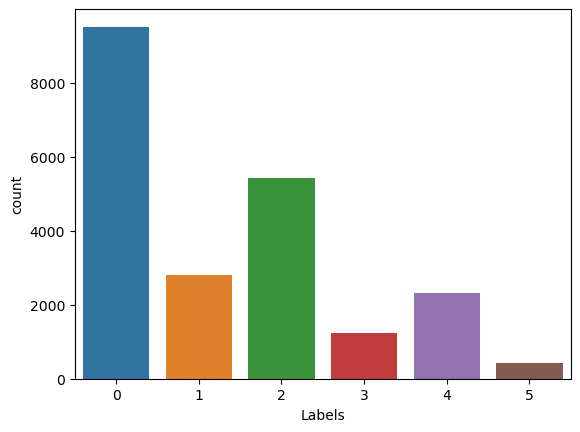

In [11]:
sns.countplot(data=final_data,x='Labels')

In [12]:
class ECG_Data(Dataset):
    def __init__(self,dataframe):
        self.data=dataframe
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self,idx):
        path='/home/ines/code/ptb-xl/'+self.data['filename_lr'][idx]
        file_audio=wfdb.rdsamp(path)
        data=file_audio
        data_new=np.array(data[0])
        data_new=np.transpose(data_new,(1,0))
        #data_final=data_new[7]
        data_final = data_new
        label=self.data['Labels'][idx]
        data_final=torch.Tensor(data_final).T.view(1,1000,12)
        return data_final, label

In [13]:
class ECG_AUG_Data(Dataset):
    def __init__(self, dataframe, noise_std=0.1):
        self.data = dataframe
        self.noise_std = noise_std  # Standard deviation of Gaussian noise

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path = '/home/ines/code/ptb-xl/' + self.data['filename_lr'][idx]
        file_audio = wfdb.rdsamp(path)
        data = np.array(file_audio[0])
        data = np.transpose(data, (1, 0))
        
        # Augment data by adding Gaussian noise
        noisy_data = data + np.random.normal(0, self.noise_std, size=data.shape)
        
        label = self.data['Labels'][idx]
        noisy_data = torch.Tensor(noisy_data).T.unsqueeze(0)  # Add channel dimension
        
        return noisy_data, label

In [14]:
class Decom_Data(Dataset):
    def __init__(self,dataframe):
        self.data=dataframe
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self,idx):
        path='/home/ines/code/ptb-xl/'+self.data['filename_lr'][idx]
        file_audio=wfdb.rdsamp(path)
        #print(file_audio[0].shape)
        data=file_audio
        data_new=np.array(data[0])
        data_new=np.transpose(data_new,(1,0))
        # use 12 leads rather only one lead
        #data_final=data_new[7]
        data_final = data_new
        label=self.data['Labels'][idx]
        data_final=torch.Tensor(data_final)
        return data_final, data_final

In [15]:
# bluring
# thickness line

In [16]:
ECG_train = final_data[final_data['strat_fold'].isin([1, 2, 3, 4, 5, 6, 7, 8])].reset_index(drop=True)
ECG_val = final_data[final_data['strat_fold'] == 9].reset_index(drop=True)
ECG_test = final_data[final_data['strat_fold'] == 10].reset_index(drop=True)

ECG_train = ECG_train[ECG_train['Labels'].isin([0,1,2,3,4])].reset_index(drop=True)
ECG_val = ECG_val[ECG_val['Labels'].isin([0,1,2,3,4])].reset_index(drop=True)
ECG_test = ECG_test[ECG_test['Labels'].isin([0,1,2,3,4])].reset_index(drop=True)
ECG_aug = ECG_train[ECG_train['Labels'].isin([1,2,3,4])].reset_index(drop=True)

# ECG_train=ECG_train.reset_index()
# ECG_test=ECG_test.reset_index()

tr_dataset = ECG_Data(ECG_train)
tr_aug_dataset = ECG_AUG_Data(ECG_aug)
train_dataset = ConcatDataset([tr_dataset, tr_aug_dataset])
train_loader = DataLoader(train_dataset,batch_size=64, shuffle=True)

val_dataset=ECG_Data(ECG_val)
val_loader=DataLoader(val_dataset,batch_size=64, shuffle=True)
test_dataset=ECG_Data(ECG_test)
test_loader=DataLoader(test_dataset,batch_size=64, shuffle=True)

first_batch, label = next(iter(train_loader))
 
print(f"Batch shape: {first_batch.shape}")

Batch shape: torch.Size([64, 1, 1000, 12])


In [17]:
class SubSpectralNorm(nn.Module):
    def __init__(self, num_features, spec_groups=16, affine="Sub", batch=True, dim=2):
        super().__init__()
        self.spec_groups = spec_groups
        self.affine_all = False
        affine_norm = False
        if (
            affine == "Sub"
        ):  # affine transform for each sub group. use affine of torch implementation
            affine_norm = True
        elif affine == "All":
            self.affine_all = True
            self.weight = nn.Parameter(torch.ones((1, num_features, 1, 1)))
            self.bias = nn.Parameter(torch.zeros((1, num_features, 1, 1)))
        if batch:
            self.ssnorm = nn.BatchNorm2d(num_features * spec_groups, affine=affine_norm)
        else:
            self.ssnorm = nn.InstanceNorm2d(num_features * spec_groups, affine=affine_norm)
        self.sub_dim = dim

    def forward(self, x):  # when dim h is frequency dimension
        if self.sub_dim in (3, -1):
            x = x.transpose(2, 3)
            x = x.contiguous()
        b, c, h, w = x.size()
        assert h % self.spec_groups == 0
        x = x.view(b, c * self.spec_groups, h // self.spec_groups, w)
        x = self.ssnorm(x)
        x = x.view(b, c, h, w)
        if self.affine_all:
            x = x * self.weight + self.bias
        if self.sub_dim in (3, -1):
            x = x.transpose(2, 3)
            x = x.contiguous()
        return x
class ConvBNReLU(nn.Module):
    def __init__(
        self,
        in_plane,
        out_plane,
        idx,
        kernel_size=3,
        stride=1,
        groups=1,
        use_dilation=False,
        activation=True,
        swish=False,
        BN=True,
        ssn=False,
    ):
        super().__init__()

        def get_padding(kernel_size, use_dilation):
            rate = 1  # dilation rate
            padding_len = (kernel_size - 1) // 2
            if use_dilation and kernel_size > 1:
                rate = int(2**self.idx)
                padding_len = rate * padding_len
            return padding_len, rate

        self.idx = idx

        # padding and dilation rate
        if isinstance(kernel_size, (list, tuple)):
            padding = []
            rate = []
            for k_size in kernel_size:
                temp_padding, temp_rate = get_padding(k_size, use_dilation)
                rate.append(temp_rate)
                padding.append(temp_padding)
        else:
            padding, rate = get_padding(kernel_size, use_dilation)

        # convbnrelu block
        layers = []
        layers.append(
            nn.Conv2d(in_plane, out_plane, kernel_size, stride, padding, rate, groups, bias=False)
        )
        if ssn:
            layers.append(SubSpectralNorm(out_plane, 5))
        elif BN:
            layers.append(nn.BatchNorm2d(out_plane))
        if swish:
            layers.append(nn.SiLU(True))
        elif activation:
            layers.append(nn.ReLU(True))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class BCResBlock(nn.Module):
    def __init__(self, in_plane, out_plane, idx, stride):
        super().__init__()
        self.transition_block = in_plane != out_plane
        kernel_size = (3, 3)

        # 2D part (f2)
        layers = []
        if self.transition_block:
            layers.append(ConvBNReLU(in_plane, out_plane, idx, 1, 1))
            in_plane = out_plane
        layers.append(
            ConvBNReLU(
                in_plane,
                out_plane,
                idx,
                (kernel_size[0], 1),
                (stride[0], 1),
                groups=in_plane,
                ssn=True,
                activation=False,
            )
        )
        self.f2 = nn.Sequential(*layers)
        self.avg_gpool = nn.AdaptiveAvgPool2d((1, None))

        # 1D part (f1)
        self.f1 = nn.Sequential(
            ConvBNReLU(
                out_plane,
                out_plane,
                idx,
                (1, kernel_size[1]),
                (1, stride[1]),
                groups=out_plane,
                swish=True,
                use_dilation=True,
            ),
            nn.Conv2d(out_plane, out_plane, 1, bias=False),
            nn.Dropout2d(0.1),
        )

    def forward(self, x):
        # 2D part
        shortcut = x
        x = self.f2(x)
        aux_2d_res = x
        x = self.avg_gpool(x)

        # 1D part
        x = self.f1(x)
        x = x + aux_2d_res
        if not self.transition_block:
            x = x + shortcut
        x = F.relu(x, True)
        return x


def BCBlockStage(num_layers, last_channel, cur_channel, idx, use_stride):
    stage = nn.ModuleList()
    channels = [last_channel] + [cur_channel] * num_layers
    for i in range(num_layers):
        stride = (2, 1) if use_stride and i == 0 else (1, 1)
        stage.append(BCResBlock(channels[i], channels[i + 1], idx, stride))
    return stage


class BCResNets(nn.Module):
    def __init__(self, base_c, num_classes=5):
        super().__init__()
        self.num_classes = num_classes
        self.n = [2, 2, 4, 4]  # identical modules repeated n times
        self.c = [
            base_c * 2,
            base_c,
            int(base_c * 1.5),
            base_c * 2,
            int(base_c * 2.5),
            base_c * 4,
        ]  # num channels
        self.s = [1, 2]  # stage using stride
        self._build_network()

    def _build_network(self):
        # Head: (Conv-BN-ReLU)
        self.cnn_head = nn.Sequential(
            nn.Conv2d(1, self.c[0], 5, (2, 1), 2, bias=False),
            nn.BatchNorm2d(self.c[0]),
            nn.ReLU(True),
        )
        # Body: BC-ResBlocks
        self.BCBlocks = nn.ModuleList([])
        for idx, n in enumerate(self.n):
            use_stride = idx in self.s
            self.BCBlocks.append(BCBlockStage(n, self.c[idx], self.c[idx + 1], idx, use_stride))

        # Classifier
        self.classifier = nn.Sequential(
            nn.Conv2d(
                self.c[-2], self.c[-2], (5, 5), bias=False, groups=self.c[-2], padding=(0, 2)
            ),
            nn.Conv2d(self.c[-2], self.c[-1], 1, bias=False),
            nn.BatchNorm2d(self.c[-1]),
            nn.ReLU(True),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(self.c[-1], self.num_classes, 1),
        )

    def forward(self, x):
        x = self.cnn_head(x)
        for i, num_modules in enumerate(self.n):
            for j in range(num_modules):
                #print(x.shape)
                x = self.BCBlocks[i][j](x)
                #print(x.shape)
        x = self.classifier(x)
        x = x.view(-1, x.shape[1])
        return x

In [18]:
tau = 8
model = BCResNets(int(tau * 8), 6)
sample = torch.randn(1,1,1000,12)
print(sample.shape)
pred = model(sample)
pred.shape

torch.Size([1, 1, 1000, 12])


torch.Size([1, 6])

In [18]:
'''
Decom_train,Decom_test=train_test_split(final_data, test_size=0.2, random_state=42)
Decom_train=Decom_train.reset_index()
Decom_test=Decom_test.reset_index()


DCtrain_dataset = Decom_Data(Decom_train)
DCtrain_loader=DataLoader(DCtrain_dataset,batch_size=64)
DCtest_dataset=Decom_Data(Decom_test)
DCtest_loader=DataLoader(DCtest_dataset,batch_size=64)
'''

In [47]:
first_batch, _ = next(iter(DCtrain_loader))
 
print(f"Batch shape: {first_batch.shape}")

NameError: name 'DCtrain_loader' is not defined

In [20]:
first_batch, _ = next(iter(train_loader))
 
print(f"Batch shape: {first_batch.shape}")

Batch shape: torch.Size([64, 1, 120, 100])


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
num_epochs = 50
#model = DecomNet().to(device)
tau = 1
model = BCResNets(int(tau * 8), 5).to(device)
warmup_epoch = 5
n_step_warmup = len(train_loader) * warmup_epoch
total_iter = len(train_loader) * num_epochs
iterations = 0
init_lr = 1e-2
lr_lower_limit = 0

optim = torch.optim.Adam(model.parameters(), lr=init_lr, weight_decay=0.0001)
loss_fn = torch.nn.CrossEntropyLoss()

def acc(op, labels):
    op = torch.softmax(op, dim=1)
    _, preds = torch.max(op, dim=1)
    return (preds == labels).float().mean()

for epoch in range(num_epochs):
    model.train()
    train_accuracy = []
    train_loss_sum = 0
    for data, label in train_loader:
        iterations += 1
        if iterations < n_step_warmup:
            lr = init_lr * iterations / n_step_warmup
        else:
            lr = lr_lower_limit + 0.5 * (init_lr - lr_lower_limit) * (
                1
                + np.cos(
                    np.pi * (iterations - n_step_warmup) / (total_iter - n_step_warmup)
                )
            )
        for param_group in optim.param_groups:
            param_group["lr"] = lr
            
        data, label = data.to(device), label.to(device) 

        optim.zero_grad()
        output = model(data)
        loss_value = loss_fn(output, label)
        loss_value.backward()
        optim.step()

        train_loss_sum += loss_value.item()
        train_accuracy.append(acc(output, label).item())

    avg_train_accuracy = np.mean(train_accuracy)
    avg_train_loss = train_loss_sum / len(train_loader)
    print(f'Epoch: {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.2f}%')

    model.eval()
    val_accuracy = []
    val_loss_sum = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(device), label.to(device)

            output = model(data)
            loss_value = loss_fn(output, label)

            val_loss_sum += loss_value.item()
            val_accuracy.append(acc(output, label).item())

            y_true.extend(label.cpu().numpy())
            y_pred.extend(torch.softmax(output, dim=1).cpu().numpy())

    avg_val_accuracy = np.mean(val_accuracy)
    avg_val_loss = val_loss_sum / len(val_loader)
    print(f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.2f}%')

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate macro AUC
    macro_auc_ovo = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovo')
    macro_auc_ovr = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr')
    print(f'Macro AUC: {macro_auc_ovo:.4f}, {macro_auc_ovr:.4f}')

Using cuda device
Epoch: 1/50, Training Loss: 1.3087, Training Accuracy: 0.43%
Val Loss: 0.9885, Val Accuracy: 0.61%
Macro AUC: 0.8079, 0.8356
Epoch: 2/50, Training Loss: 0.9610, Training Accuracy: 0.61%
Val Loss: 0.9330, Val Accuracy: 0.62%
Macro AUC: 0.8623, 0.8733
Epoch: 3/50, Training Loss: 0.8415, Training Accuracy: 0.67%
Val Loss: 1.1202, Val Accuracy: 0.63%
Macro AUC: 0.8391, 0.8732
Epoch: 4/50, Training Loss: 0.7747, Training Accuracy: 0.70%
Val Loss: 0.8912, Val Accuracy: 0.67%
Macro AUC: 0.8735, 0.8929
Epoch: 5/50, Training Loss: 0.7396, Training Accuracy: 0.72%
Val Loss: 0.7606, Val Accuracy: 0.71%
Macro AUC: 0.8900, 0.9091
Epoch: 6/50, Training Loss: 0.7134, Training Accuracy: 0.73%
Val Loss: 0.7478, Val Accuracy: 0.72%
Macro AUC: 0.8916, 0.9113
Epoch: 7/50, Training Loss: 0.6946, Training Accuracy: 0.74%
Val Loss: 0.7943, Val Accuracy: 0.71%
Macro AUC: 0.8993, 0.9079
Epoch: 8/50, Training Loss: 0.6793, Training Accuracy: 0.74%
Val Loss: 0.7844, Val Accuracy: 0.71%
Macro AU

KeyboardInterrupt: 

In [24]:
def count_parameters(model):
    return sum(torch.numel(parameter) for parameter in model.parameters())

print(f"Total parameters: {count_parameters(model)}")

Total parameters: 9001


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
num_epochs = 50
#model = DecomNet().to(device)
tau = 6
model = BCResNets(int(tau * 8), 5).to(device)
warmup_epoch = 5
n_step_warmup = len(train_loader) * warmup_epoch
total_iter = len(train_loader) * num_epochs
iterations = 0
init_lr = 1e-2
lr_lower_limit = 0

optim = torch.optim.Adam(model.parameters(), lr=init_lr, weight_decay=0.0001)
loss_fn = torch.nn.CrossEntropyLoss()

def acc(op, labels):
    op = torch.softmax(op, dim=1)
    _, preds = torch.max(op, dim=1)
    return (preds == labels).float().mean()

for epoch in range(num_epochs):
    model.train()
    train_accuracy = []
    train_loss_sum = 0
    for data, label in train_loader:
        iterations += 1
        if iterations < n_step_warmup:
            lr = init_lr * iterations / n_step_warmup
        else:
            lr = lr_lower_limit + 0.5 * (init_lr - lr_lower_limit) * (
                1
                + np.cos(
                    np.pi * (iterations - n_step_warmup) / (total_iter - n_step_warmup)
                )
            )
        for param_group in optim.param_groups:
            param_group["lr"] = lr
            
        data, label = data.to(device), label.to(device) 

        optim.zero_grad()
        output = model(data)
        loss_value = loss_fn(output, label)
        loss_value.backward()
        optim.step()

        train_loss_sum += loss_value.item()
        train_accuracy.append(acc(output, label).item())

    avg_train_accuracy = np.mean(train_accuracy)
    avg_train_loss = train_loss_sum / len(train_loader)
    print(f'Epoch: {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.2f}%')

    model.eval()
    val_accuracy = []
    val_loss_sum = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(device), label.to(device)

            output = model(data)
            loss_value = loss_fn(output, label)

            val_loss_sum += loss_value.item()
            val_accuracy.append(acc(output, label).item())

            y_true.extend(label.cpu().numpy())
            y_pred.extend(torc h.softmax(output, dim=1).cpu().numpy())

    avg_val_accuracy = np.mean(val_accuracy)
    avg_val_loss = val_loss_sum / len(val_loader)
    print(f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.2f}%')

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate macro AUC
    macro_auc_ovo = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovo')
    macro_auc_ovr = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr')
    print(f'Macro AUC: {macro_auc_ovo:.4f}, {macro_auc_ovr:.4f}')

Using cuda device
Epoch: 1/50, Training Loss: 1.0344, Training Accuracy: 0.58%
Val Loss: 0.9467, Val Accuracy: 0.65%
Macro AUC: 0.8413, 0.8609
Epoch: 2/50, Training Loss: 0.7748, Training Accuracy: 0.70%
Val Loss: 0.8183, Val Accuracy: 0.68%
Macro AUC: 0.8788, 0.8997
Epoch: 3/50, Training Loss: 0.6999, Training Accuracy: 0.74%
Val Loss: 0.8641, Val Accuracy: 0.66%
Macro AUC: 0.8858, 0.8975
Epoch: 4/50, Training Loss: 0.6699, Training Accuracy: 0.75%
Val Loss: 0.8390, Val Accuracy: 0.68%
Macro AUC: 0.8857, 0.9014
Epoch: 5/50, Training Loss: 0.6490, Training Accuracy: 0.75%
Val Loss: 0.7432, Val Accuracy: 0.73%
Macro AUC: 0.9018, 0.9150
Epoch: 6/50, Training Loss: 0.6363, Training Accuracy: 0.76%
Val Loss: 0.9724, Val Accuracy: 0.64%
Macro AUC: 0.8905, 0.8990
Epoch: 7/50, Training Loss: 0.6214, Training Accuracy: 0.77%
Val Loss: 0.8436, Val Accuracy: 0.66%
Macro AUC: 0.9053, 0.9152
Epoch: 8/50, Training Loss: 0.6086, Training Accuracy: 0.77%
Val Loss: 0.8596, Val Accuracy: 0.71%
Macro AU

KeyboardInterrupt: 

In [21]:
model.eval()
test_accuracy = []
test_loss_sum = 0
y_true = []
y_pred = []
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label.to(device)

        output = model(data)
        loss_value = loss_fn(output, label)

        test_loss_sum += loss_value.item()
        test_accuracy.append(acc(output, label).item())

        y_true.extend(label.cpu().numpy())
        y_pred.extend(torch.softmax(output, dim=1).cpu().numpy())

avg_test_accuracy = np.mean(test_accuracy)
avg_test_loss = test_loss_sum / len(test_loader)
print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.2f}%')

Test Loss: 0.7628, Test Accuracy: 0.73%


              precision    recall  f1-score   support

        NORM       0.77      0.92      0.84       963
        STTC       0.64      0.50      0.56       283
          MI       0.79      0.62      0.70       544
         HYP       0.58      0.28      0.38       117
          CD       0.55      0.65      0.60       245

    accuracy                           0.73      2152
   macro avg       0.67      0.60      0.62      2152
weighted avg       0.72      0.73      0.71      2152



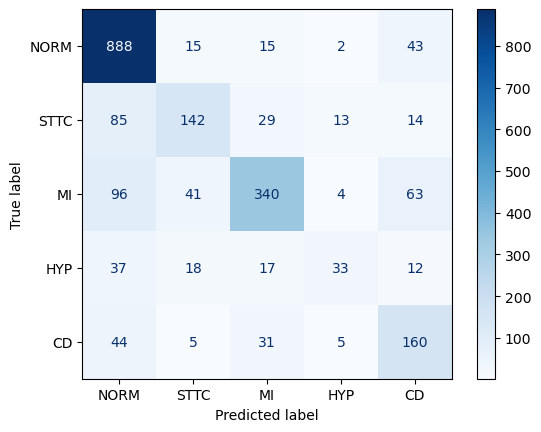

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

display_labels = ['NORM', 'STTC', 'MI', 'HYP', 'CD']

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate classification report
report = classification_report(y_true, y_pred_classes, target_names=display_labels)
print(report)  # Print classification report

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(include_values=True, cmap='Blues', xticks_rotation='horizontal', values_format='d')
plt.show()


In [49]:
path = '/home/ines/code/
torch.save(model.state_dict(), path)

conv1.weight 	 torch.Size([16, 1, 5, 1])
conv1.bias 	 torch.Size([16])
conv2.weight 	 torch.Size([32, 16, 5, 1])
conv2.bias 	 torch.Size([32])
conv3.weight 	 torch.Size([64, 32, 5, 1])
conv3.bias 	 torch.Size([64])
conv4.weight 	 torch.Size([128, 64, 5, 1])
conv4.bias 	 torch.Size([128])
bn1.weight 	 torch.Size([16])
bn1.bias 	 torch.Size([16])
bn1.running_mean 	 torch.Size([16])
bn1.running_var 	 torch.Size([16])
bn1.num_batches_tracked 	 torch.Size([])
bn2.weight 	 torch.Size([32])
bn2.bias 	 torch.Size([32])
bn2.running_mean 	 torch.Size([32])
bn2.running_var 	 torch.Size([32])
bn2.num_batches_tracked 	 torch.Size([])
bn3.weight 	 torch.Size([64])
bn3.bias 	 torch.Size([64])
bn3.running_mean 	 torch.Size([64])
bn3.running_var 	 torch.Size([64])
bn3.num_batches_tracked 	 torch.Size([])
bn4.weight 	 torch.Size([128])
bn4.bias 	 torch.Size([128])
bn4.running_mean 	 torch.Size([128])
bn4.running_var 	 torch.Size([128])
bn4.num_batches_tracked 	 torch.Size([])
fc3.weight 	 torch.Size([5,

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
num_epochs = 50
#model = DecomNet().to(device)
tau = 1
model = BCResNets(int(tau * 8), 5).to(device)
warmup_epoch = 5
n_step_warmup = len(train_loader) * warmup_epoch
total_iter = len(train_loader) * num_epochs
iterations = 0
init_lr = 1e-2
lr_lower_limit = 0

optim = torch.optim.Adam(model.parameters(), lr=init_lr)
loss_fn = torch.nn.CrossEntropyLoss()

def acc(op, labels):
    op = torch.softmax(op, dim=1)
    _, preds = torch.max(op, dim=1)
    return (preds == labels).float().mean()

for epoch in range(num_epochs):
    model.train()
    train_accuracy = []
    train_loss_sum = 0
    for data, label in train_loader:
        iterations += 1
        if iterations < n_step_warmup:
            lr = init_lr * iterations / n_step_warmup
        else:
            lr = lr_lower_limit + 0.5 * (init_lr - lr_lower_limit) * (
                1
                + np.cos(
                    np.pi * (iterations - n_step_warmup) / (total_iter - n_step_warmup)
                )
            )
        for param_group in optim.param_groups:
            param_group["lr"] = lr
            
        data, label = data.to(device), label.to(device) 

        optim.zero_grad()
        output = model(data)
        loss_value = loss_fn(output, label)
        loss_value.backward()
        optim.step()

        train_loss_sum += loss_value.item()
        train_accuracy.append(acc(output, label).item())

    avg_train_accuracy = np.mean(train_accuracy)
    avg_train_loss = train_loss_sum / len(train_loader)
    print(f'Epoch: {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.2f}%')

    model.eval()
    val_accuracy = []
    val_loss_sum = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(device), label.to(device)

            output = model(data)
            loss_value = loss_fn(output, label)

            val_loss_sum += loss_value.item()
            val_accuracy.append(acc(output, label).item())

            y_true.extend(label.cpu().numpy())
            y_pred.extend(torch.softmax(output, dim=1).cpu().numpy())

    avg_val_accuracy = np.mean(val_accuracy)
    avg_val_loss = val_loss_sum / len(val_loader)
    print(f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.2f}%')

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate macro AUC
    macro_auc_ovo = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovo')
    macro_auc_ovr = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr')
    print(f'Macro AUC: {macro_auc_ovo:.4f}, {macro_auc_ovr:.4f}')

Using cuda device


KeyboardInterrupt: 

In [21]:
class DecomNet(nn.Module):
    def __init__(self):
        super(DecomNet, self).__init__()

        # (12, 1000)을 (4, 1000)과 (4, 12)로 분리하기 위한 Conv1d 레이어
        self.network_1 = nn.Sequential(
            nn.Conv1d(in_channels=12, out_channels=6, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=6, out_channels=3, kernel_size=1),
        )
        self.network_2 = nn.Sequential(
            nn.Conv1d(in_channels=1000, out_channels=6, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=6, out_channels=3, kernel_size=1),
        )
        
    def forward(self, x):
        out1 = self.network_1(x)
        out2 = self.network_2(torch.transpose(x, 1, 2))
        return out1, out2

In [47]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(5,1), stride=(2,1), padding=(2,0))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,1), stride=(2,1), padding=(2,0))
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,1), stride=(2,1), padding=(2,0))
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5,1), stride=(2,1), padding=(2,0))
        
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        
        
        self.fc3 = nn.Linear(128, 5)  # 6 classes

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        
        # Global Average Pooling
        x = F.adaptive_avg_pool2d(x,1)
        x = x.view(-1, 128)
        x = self.fc3(x)
        return x

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
num_epochs = 50
#model = DecomNet().to(device)
tau = 6
model = SimpleCNN().to(device)
warmup_epoch = 5
n_step_warmup = len(train_loader) * warmup_epoch
total_iter = len(train_loader) * num_epochs
iterations = 0
init_lr = 1e-2
lr_lower_limit = 0

optim = torch.optim.Adam(model.parameters(), lr=init_lr)
loss_fn = torch.nn.CrossEntropyLoss()

def acc(op, labels):
    op = torch.softmax(op, dim=1)
    _, preds = torch.max(op, dim=1)
    return (preds == labels).float().mean()

for epoch in range(num_epochs):
    model.train()
    train_accuracy = []
    train_loss_sum = 0
    for data, label in train_loader:
        iterations += 1
        if iterations < n_step_warmup:
            lr = init_lr * iterations / n_step_warmup
        else:
            lr = lr_lower_limit + 0.5 * (init_lr - lr_lower_limit) * (
                1
                + np.cos(
                    np.pi * (iterations - n_step_warmup) / (total_iter - n_step_warmup)
                )
            )
        for param_group in optim.param_groups:
            param_group["lr"] = lr
            
        data, label = data.to(device), label.to(device) 

        optim.zero_grad()
        output = model(data)
        loss_value = loss_fn(output, label)
        loss_value.backward()
        optim.step()

        train_loss_sum += loss_value.item()
        train_accuracy.append(acc(output, label).item())

    avg_train_accuracy = np.mean(train_accuracy)
    avg_train_loss = train_loss_sum / len(train_loader)
    print(f'Epoch: {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.2f}%')

    model.eval()
    val_accuracy = []
    val_loss_sum = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(device), label.to(device)

            output = model(data)
            loss_value = loss_fn(output, label)

            val_loss_sum += loss_value.item()
            val_accuracy.append(acc(output, label).item())

            y_true.extend(label.cpu().numpy())
            y_pred.extend(torch.softmax(output, dim=1).cpu().numpy())

    avg_val_accuracy = np.mean(val_accuracy)
    avg_val_loss = val_loss_sum / len(val_loader)
    print(f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.2f}%')

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate macro AUC
    macro_auc_ovo = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovo')
    macro_auc_ovr = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr')
    print(f'Macro AUC: {macro_auc_ovo:.4f}, {macro_auc_ovr:.4f}')

Using cuda device
Epoch: 1/50, Training Loss: 1.1153, Training Accuracy: 0.57%
Val Loss: 1.7199, Val Accuracy: 0.33%
Macro AUC: 0.8268, 0.8246
Epoch: 2/50, Training Loss: 0.8368, Training Accuracy: 0.69%
Val Loss: 2.0582, Val Accuracy: 0.44%
Macro AUC: 0.8442, 0.8585
Epoch: 3/50, Training Loss: 0.7777, Training Accuracy: 0.71%
Val Loss: 1.1081, Val Accuracy: 0.59%
Macro AUC: 0.8784, 0.8770
Epoch: 4/50, Training Loss: 0.7433, Training Accuracy: 0.72%
Val Loss: 1.0335, Val Accuracy: 0.58%
Macro AUC: 0.8634, 0.8788
Epoch: 5/50, Training Loss: 0.7393, Training Accuracy: 0.73%
Val Loss: 1.1553, Val Accuracy: 0.54%
Macro AUC: 0.8854, 0.8879
Epoch: 6/50, Training Loss: 0.7229, Training Accuracy: 0.74%
Val Loss: 0.7691, Val Accuracy: 0.73%
Macro AUC: 0.8870, 0.9100
Epoch: 7/50, Training Loss: 0.6983, Training Accuracy: 0.74%
Val Loss: 0.8464, Val Accuracy: 0.69%
Macro AUC: 0.9052, 0.9140
Epoch: 8/50, Training Loss: 0.6843, Training Accuracy: 0.75%
Val Loss: 0.9157, Val Accuracy: 0.67%
Macro AU

KeyboardInterrupt: 

In [53]:
from sklearn.metrics import roc_auc_score
macro_auc = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovo')
print(f'Macro AUC: {macro_auc:.4f}')

Macro AUC: 0.5727


In [55]:
macro_auc = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr')
print(f'Macro AUC: {macro_auc:.4f}')

Macro AUC: 0.5870


In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

#model = DecomNet().to(device)
tau = 8
model = BCResNets(int(tau * 8)).to(device)

optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()


num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss_sum = 0
    for data, label in DCtrain_loader:
        data, label = data.to(device), label.to(device)

        optim.zero_grad()
        output1, output2 = model(data)

        loss_value = loss_fn(torch.sigmoid(torch.bmm(output2.permute(0, 2, 1), output1)), label)
        loss_value.backward()
        optim.step()

        train_loss_sum += loss_value.item()

    avg_train_loss = train_loss_sum / len(train_loader)
    print(f'Epoch: {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}')

    model.eval()
    test_loss_sum = 0
    with torch.no_grad():
        for data, label in DCtest_loader:
            data, label = data.to(device), label.to(device)

            optim.zero_grad()
            output1, output2 = model(data)
            loss_value = loss_fn(torch.sigmoid(torch.bmm(output2.permute(0, 2, 1), output1)), label)
            test_loss_sum += loss_value.item()

    avg_test_loss = test_loss_sum / len(test_loader)
    print(f'Test Loss: {avg_test_loss:.4f}')


Using cuda device
Epoch: 1/50, Training Loss: 0.0782
Test Loss: 0.0487
Epoch: 2/50, Training Loss: 0.0510
Test Loss: 0.0462
Epoch: 3/50, Training Loss: 0.0494
Test Loss: 0.0448
Epoch: 4/50, Training Loss: 0.0483
Test Loss: 0.0446
Epoch: 5/50, Training Loss: 0.0479
Test Loss: 0.0443
Epoch: 6/50, Training Loss: 0.0476
Test Loss: 0.0445
Epoch: 7/50, Training Loss: 0.0474
Test Loss: 0.0442
Epoch: 8/50, Training Loss: 0.0470
Test Loss: 0.0442
Epoch: 9/50, Training Loss: 0.0469
Test Loss: 0.0441
Epoch: 10/50, Training Loss: 0.0469
Test Loss: 0.0442
Epoch: 11/50, Training Loss: 0.0467
Test Loss: 0.0443
Epoch: 12/50, Training Loss: 0.0467
Test Loss: 0.0441
Epoch: 13/50, Training Loss: 0.0467
Test Loss: 0.0442
Epoch: 14/50, Training Loss: 0.0470
Test Loss: 0.0442
Epoch: 15/50, Training Loss: 0.0467
Test Loss: 0.0441
Epoch: 16/50, Training Loss: 0.0465
Test Loss: 0.0439
Epoch: 17/50, Training Loss: 0.0464
Test Loss: 0.0439


KeyboardInterrupt: 

In [84]:
channel = 6
loss_fn(torch.bmm(output2.permute(0, 2, 1), output1)[idx,channel,:] , label[idx,channel,:])

tensor(0.0284, device='cuda:0')

In [88]:
torch.bmm(output2.permute(0, 2, 1), output1)[idx,channel,:50]

tensor([ 0.0733,  0.0726,  0.0712,  0.0723,  0.0732,  0.0758,  0.0749,  0.0851,
         0.0941,  0.0965,  0.1089,  0.0977,  0.0735,  0.0661,  0.0577,  0.0525,
         0.0496,  0.0426,  0.0415,  0.0384,  0.0411,  0.0408,  0.0401,  0.0664,
         0.1754,  0.4349,  0.4254, -0.0593, -0.1735, -0.0518,  0.0086,  0.0469,
         0.0490,  0.0554,  0.0606,  0.0611,  0.0665,  0.0716,  0.0765,  0.0766,
         0.0780,  0.0845,  0.0886,  0.0898,  0.0974,  0.1015,  0.1085,  0.1238,
         0.1298,  0.1310], device='cuda:0')

In [89]:
label[idx,channel,:50]

tensor([ 0.0510,  0.0440,  0.0500,  0.0510,  0.0450,  0.0410,  0.0370,  0.0250,
         0.0120,  0.0030, -0.0060, -0.0030,  0.0190,  0.0460,  0.0540,  0.0580,
         0.0660,  0.0680,  0.0660,  0.0660,  0.0650,  0.0840,  0.1010,  0.1000,
         0.0240, -0.3910, -0.5550, -0.1690, -0.0090, -0.0150,  0.0000,  0.0010,
         0.0470,  0.0420,  0.0370,  0.0370,  0.0280,  0.0220,  0.0200,  0.0240,
         0.0250,  0.0300,  0.0320,  0.0260,  0.0180,  0.0180,  0.0210, -0.0010,
        -0.0100, -0.0030], device='cuda:0')

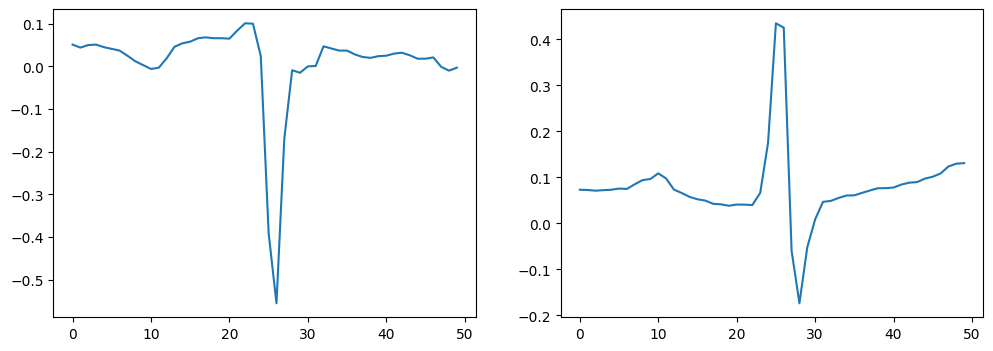

In [87]:
idx = 1
channel = 3
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(label[idx,channel,:50].cpu())

plt.subplot(122)
plt.plot(torch.bmm(output2.permute(0, 2, 1), output1)[idx,channel,:50].cpu())

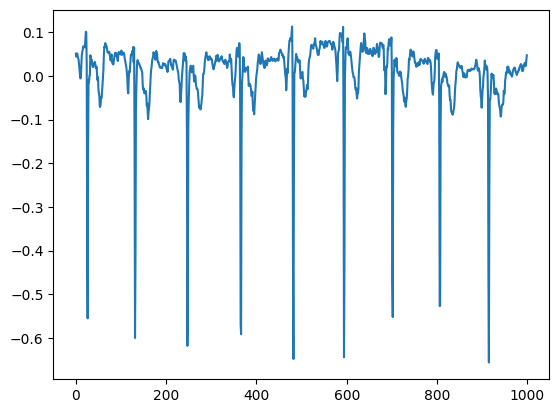

In [77]:
plt.plot(data[idx,channel,:].cpu())

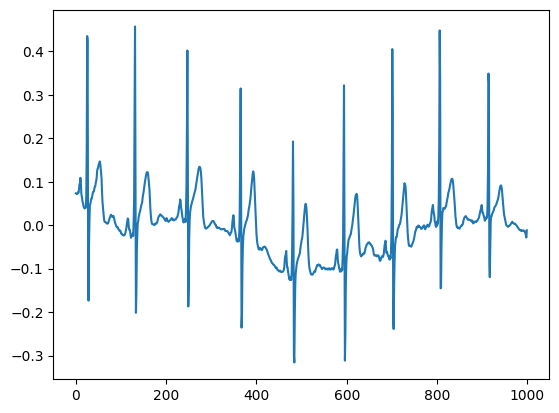

In [78]:
plt.plot(torch.bmm(output2.permute(0, 2, 1), output1)[idx,channel,:].cpu())

In [16]:
class ECGTransformer(nn.Module):
    def __init__(self, input_dim, model_dim=512, nhead=8, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=2048, dropout=0.1):
        super(ECGTransformer, self).__init__()

        self.model_dim = model_dim
        self.pos_encoder = PositionalEncoding(model_dim, dropout)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)
        self.decoder = nn.Linear(model_dim, 6)  # 6 is the number of classes
        self.src_mask = None
        self.input_linear = nn.Linear(input_dim, model_dim)  # Adapt input dimension to model dimension
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.input_linear.bias.data.zero_()
        self.input_linear.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        src = self.input_linear(src)  
        src = self.pos_encoder(src)   
        output = self.transformer_encoder(src)  
        output = self.decoder(output.mean(dim=1)) 
        return F.log_softmax(output, dim=-1) 

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

model = ECGTransformer(input_dim=1, model_dim=512).to(device)

optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

def acc(op, labels):
    op = torch.softmax(op, dim=1)
    _, preds = torch.max(op, dim=1)
    return (preds == labels).float().mean()

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_accuracy = []
    train_loss_sum = 0
    for data, label in train_loader:
        data, label = data.to(device), label.to(device)
        data = data.unsqueeze(-1)  

        optim.zero_grad()
        output = model(data)
        loss_value = loss_fn(output, label)
        loss_value.backward()
        optim.step()

        train_loss_sum += loss_value.item()
        train_accuracy.append(acc(output, label).item())

    avg_train_accuracy = np.mean(train_accuracy)
    avg_train_loss = train_loss_sum / len(train_loader)
    print(f'Epoch: {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.2f}%')

    model.eval()
    test_accuracy = []
    test_loss_sum = 0
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            data = data.unsqueeze(-1)

            output = model(data)
            loss_value = loss_fn(output, label)

            test_loss_sum += loss_value.item()
            test_accuracy.append(acc(output, label).item())

    avg_test_accuracy = np.mean(test_accuracy)
    avg_test_loss = test_loss_sum / len(test_loader)
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.2f}%')
